In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import os

from IPython.display import HTML
from IPython.display import display_html

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* "Microsoft.WebBrowser.Protobuf.UMA.Histograms\\"
    * shows up both in continuous and discrete queries; is this a special type of data-structure?
    
* Questions
    * 'attribute': {'name': 'Confidence:3', 'dataType': 'Double'}, 'values': ['0.5D'], 'children': [], 'isSorted': True} ----> why are column names of the type col_name:%d
    * example when PartitioningColumn not in inputColumns:
        device_id v/s DeviceID
        others?
    * sometimes filter input column something like: partialRowNum0


* TODO: combine this with join tables data; Probably can't draw a lot of conclusion about partitioning etc. w/o considering the join workload

* NormInput vs HashTagInput
* inputSelected vs inputColumns
* #FilterColumns vs #FilterColumnsPerSQL. FilterColumns separate plot;
    * #FilterColumns total used for input
    * #Mean, max/min/std filter columns per job per input
* PartitioningColumn Questions:
    * PartitionColumns vs FilterColumns; How often are these the same??
    * #PartitioningColumn
    * Sanity Check: for an input, the #PartitioningColumn (std) == 0??
    * when are partitionin columns === nan / 0; how often / why? does this mean rr partitioning, or something else?
    * only one column is DESC, 550 are ASC!
* Whats up w/ the outlier inputs, e.g., one with inputColumns std peaking at 100??

* Operator questions
    * What kind of operators? distribution for each kind.
    * how often are there multiple filters on SAME column;
    * mixed operators; pairwise distributions; e.g., range + = operators are very rare
    * QUESTION: don't see ANY like operator?????
    
* VertexCount; what does this signify? how often does this change across inputs?

In [44]:
# FN = "combined-0J-2021-05-22.ss.csv"
# INP_FIELD = "NormInput"
# DEDUP_FIELDS = [INP_FIELD, FILTER_FIELD]

FN = "../data/cosmos08/raw_views_filters_2021-12-15.ss.csv"
DEDUPFN = FN.replace(".ss.csv", "-dedup.ss.csv")
INP_FIELD = "NormInputHashCode"
FILTER_FIELD = "FilterExpr"
DEDUP_FIELDS = [INP_FIELD, FILTER_FIELD]

STATCOLS = ["like_ops", "discrete_ops", "cont_ops"]
#STATSTODROP = ["std", "min", "max", "25%", "50%","75%"]
#INP_FIELD = "HashTagInput"

In [45]:
#df = pd.read_csv(FN, sep="|")
#df = pd.read_csv(FN, sep="\t")
#df = pd.read_csv(DEDUPFN, sep="\t")
if os.path.exists(DEDUPFN):
    df = pd.read_csv(DEDUPFN, sep="\t")
else:
    df = pd.read_csv(FN, sep="\t")

In [46]:
#df = df.rename(columns={"#Field:JobGUID":"jobid"})
df = df.rename(columns={"JobGUID":"jobid"})

In [47]:
df.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr'],
      dtype='object')

# Duplicate and then execute ---> we could group these together, but probably won't make a big difference in the stats we collect

In [48]:
print(len(set(df[INP_FIELD])))

27327


In [49]:
print(len(df))

916181


In [50]:
# df.groupby(["inputColumns"])["NormInput"].nunique().reset_index().sort_values(\
#     by="NormInput", ascending=False).reset_index().describe(percentiles=[0.9,0.99])

In [51]:
# df.groupby(["inputColumns","InputCardinality"])["NormInput"].nunique().reset_index()

In [52]:
def pretty_print(df):
    return display( HTML( df.to_html(index=False).replace("\\n","<br>") ) )

In [53]:
pretty_print(df.groupby([INP_FIELD, FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
                                    ascending=False)["jobid"].describe(percentiles=[0.9,0.99]).\
                                    reset_index().\
            rename(columns={"jobid":"Input, FilterExprNorm \\n Duplicates"}))

index,"Input, FilterExprNorm Duplicates"
count,916181.0
mean,1.0
std,0.0
min,1.0
50%,1.0
90%,1.0
99%,1.0
max,1.0


In [54]:
df = df.drop_duplicates(DEDUP_FIELDS, keep="last")

In [55]:
if not os.path.exists(DEDUPFN):
    df.to_csv(DEDUPFN, sep="\t", index=False)

In [56]:
#df2 = pd.read_csv(DEDUPFN)

In [57]:
#print(df2.keys())
print(df.keys())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr'],
      dtype='object')


In [58]:
def qerr(val1, val2):
    val1 = max(1, val1)
    val2 = max(1, val2)
    q = max (float(val1)/val2, float(val2)/val1)
    return q

In [ ]:
df["InputCardinality"] = df.apply(lambda x: max(1, x["InputCardinality"]), axis=1)
df["Selectivity"] = df.apply(lambda x: min(float(x["RowCount"])/x["InputCardinality"], 1.0) ,axis=1)

In [ ]:
df["QError"] = df.apply(lambda x:  qerr(x["RowCount"], x["EstCardinality"]),axis=1)

In [ ]:
#HTML(df["Selectivity"].describe(percentiles=[0.75, 0.9, 0.99]).reset_index().to_html(index=False))

# Amount of time spent in filters vs whole jobs

In [ ]:
#HTML(df[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [ ]:
#df = df[df.InclusiveTime >= 2.506925e+02]

In [ ]:
#print(set(cont_ranges))

In [ ]:
# df2 = df.sample(frac=0.01)
# parse_filter_exprs(df2, INP_FIELD, FILTER_FIELD)

In [ ]:
if False:
    dbs = defaultdict(set)
    seeninps = set()
    numdbs = 0

    for jid in set(df["jobid"]):
        tmp = df[df.jobid == jid]
        inps = tmp[INP_FIELD].values
        seendb = False
        curinps = set()
        for inp in inps:
            if inp in seeninps:
                seendb = True
                break
            curinps.add(inp)

        if not seendb:
            numdbs += 1
            for inp in inps:
                dbs[numdbs].add(inp)
            #print("numbs: ", numdbs, " total dbs: ", len(dbs))

        if seendb:
            # which db was any of the inp in?? And put others in that
            curdbs = []
            for inp in inps:
                if inp in seeninps:
                    # find the db name
                    for dbnum in dbs:
                        if inp in dbs[dbnum]:
                            curdbs.append(dbnum)

            chosendb = curdbs[0]
            curdbs = set(curdbs)
    #         if len(curdbs) != 1:
    #             print("*********************")
    #             print("Num cur dbs: ", len(curdbs))
    #             print("*********************")

            # choose first db and add everything to that
            for inp in inps:
                dbs[chosendb].add(inp)

            # merge dbs
            for otherdb in curdbs:
                if chosendb == otherdb:
                    continue
                if otherdb not in dbs:
                    continue
                dbs[chosendb] = dbs[chosendb].union(dbs[otherdb])

                #dbs[chosendb].add(dbs[otherdb])
                print("deleted: ", otherdb)
                del dbs[otherdb]

        #for cinp in curinps:
        seeninps = seeninps.union(curinps)

In [ ]:
# inptodb = {}
# for k,v in dbs.items():
#     for inp in v:
#         inptodb[inp] = k

In [ ]:
# dbcol = []
# unkn = 0
# for idx,row in df.iterrows():
#     if row[INP_FIELD] not in inptodb:
#         dbcol.append("unknown")
#         unkn += 1
#     else:
#         dbcol.append(inptodb[row[INP_FIELD]])

In [ ]:
# numtables = [len(v) for v in dbs.values()]
# print(np.mean(numtables), np.percentile(numtables, 0.5), np.percentile(numtables, 0.75), 
#      np.percentile(numtables, 0.9),
#      np.percentile(numtables, 0.99),
#      np.percentile(numtables, 0.999)
#      )

In [ ]:
# dbdf = defaultdict(list)
# for k,v in dbs.items():
#     #print(len(v))
#     dbdf["db"].append(k)
#     dbdf["numtables"].append(len(v))
# dbdf = pd.DataFrame(dbdf)

In [ ]:
#dbdf["numtables"].describe(percentiles=[0.75, 0.9, 0.99, 0.999])

In [ ]:
# tmp = dbdf[dbdf["numtables"] >= 2]
# tmp["numtables"].describe(percentiles=[0.75, 0.9, 0.99, 0.999])

In [ ]:
# import time
# start = time.time()
# parse_filter_exprs(df, INP_FIELD, FILTER_FIELD)
# print("parsing took: ", time.time()-start)

In [ ]:
#frames = [df.iloc[i*60:min((i+1)*60,len(df))] for i in range(int(len(df)/10000) + 1)]

In [ ]:
print(df.keys())

In [ ]:
import copy
tmp = copy.deepcopy(df.sample(frac=0.001))
import time
start = time.time()
tdf,_ = parse_filter_exprs2(tmp, INP_FIELD, FILTER_FIELD)
print("parsing took: ", time.time()-start)

In [ ]:
# import time
# start = time.time()
# df,allopdf = parse_filter_exprs2(df, INP_FIELD, FILTER_FIELD)
# print("parsing took: ", time.time()-start)

In [ ]:
print(df.keys())

In [ ]:
#initdf = copy.deepcopy(df)

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

In [41]:
import time
start = time.time()
df,allopdf = parse_filter_exprs_par(df, INP_FIELD, FILTER_FIELD, num_par=32)
print("parsing took: ", time.time()-start)

!!Like in Op, but LikeUtil not!!
useraction.tolower().contains("like")
********************
!!Like in Op, but LikeUtil not!!
contentmodulelineage.toupper().contains("like")
********************
parsing took:  131.8270127773285


In [42]:
allopdf.head(50)

,column2,op,constant,opstring,dtype,optype,exprhash,input,jobid,InputCardinality,column,discrete_ops,cont_ops,like_ops
0,Query:0,!=,"""m:Query""",!=,string,!=,462337974510202744814136396390643701061785295835,-124784891,2afb509b-4200-445f-8a94-25f91508f651,1.224900e+08,-124784891Query:,1,0,0
1,FDFilter_IsMobile:8,=,false,=,bool,=,172196654126615122863816571645839210767468251998,1636185057,a17ca6ba-1693-4073-8e8d-c75cff415e68,4.485550e+09,1636185057FDFilter_IsMobile:,1,0,0
2,MSIP:17,=,false,=,bool,=,172196654126615122863816571645839210767468251998,1636185057,a17ca6ba-1693-4073-8e8d-c75cff415e68,4.485550e+09,1636185057MSIP:,1,0,0
3,FD_DeploymentId:14,>=,53777110,>=,int,>=,172196654126615122863816571645839210767468251998,1636185057,a17ca6ba-1693-4073-8e8d-c75cff415e68,4.485550e+09,1636185057FD_DeploymentId:,0,1,0
4,SS_Request_RequestTime:7,>=,1636806600.0,>=,date,>=,1318360397040063118312371870658893695603483582692,1812288802,cf359898-45d0-483e-860d-3c8d40c9c998,1.454370e+10,1812288802SS_Request_RequestTime:,0,1,0
5,SS_Request_RequestTime:7,<=,1636808400.0,<=,date,<=,1318360397040063118312371870658893695603483582692,1812288802,cf359898-45d0-483e-860d-3c8d40c9c998,1.454370e+10,1812288802SS_Request_RequestTime:,0,1,0
6,SS_Request_RequestTime:1023,>=,1636806600.0,>=,date,>=,753584435787886469700553946629414892875271958511,1495913018,cf359898-45d0-483e-860d-3c8d40c9c998,7.481310e+08,1495913018SS_Request_RequestTime:,0,1,0
7,SS_Request_RequestTime:1023,<=,1636808400.0,<=,date,<=,753584435787886469700553946629414892875271958511,1495913018,cf359898-45d0-483e-860d-3c8d40c9c998,7.481310e+08,1495913018SS_Request_RequestTime:,0,1,0
8,SS_Request_RequestTime:2039,>=,1636806600.0,>=,date,>=,191984090478738225539313984709789957408587010740,-79613166,cf359898-45d0-483e-860d-3c8d40c9c998,1.290910e+10,-79613166SS_Request_RequestTime:,0,1,0
9,SS_Request_RequestTime:2039,<=,1636808400.0,<=,date,<=,191984090478738225539313984709789957408587010740,-79613166,cf359898-45d0-483e-860d-3c8d40c9c998,1.290910e+10,-79613166SS_Request_RequestTime:,0,1,0


In [42]:
#print(len(df[df.num_ops == =1]))
df = df[df["num_ops"] != -1]
print(df.keys())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')


In [43]:
#df.to_csv("scope_queries.csv", index=False)

In [44]:
df.groupby(["cont_ops", "discrete_ops","like_ops", "regex_ops"])["ExclusiveTime"].sum().reset_index()\
    .sort_values(by="ExclusiveTime", ascending=False)

,cont_ops,discrete_ops,like_ops,regex_ops,ExclusiveTime
3,1,0,0,0,1.676605e+08
1,0,1,0,0,1.401580e+08
5,1,1,0,0,1.213680e+08
2,0,1,1,0,9.157473e+07
4,1,0,1,0,1.085177e+07
6,1,1,1,0,1.061366e+07
0,0,0,1,0,3.996567e+06


In [45]:
print(len(df))

3078923


# Like exploration

In [46]:
STATSTODROP = ["std", "min", "max", "99%"]

In [47]:
dflikes = df[df.like_ops == 1]
dflikes.groupby(["like_dtype"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).drop(columns=STATSTODROP)

,like_dtype,count,mean,50%,90%
6,unknown,97908.0,987.519095,0.253,7.9943
7,url,21785.0,573.494877,23.469,1102.6508
5,short,9685.0,379.383648,0.157,170.8886
4,serial,1334.0,114.158973,0.079,42.4282
3,path,1174.0,801.850990,0.000,442.2254
2,num,647.0,3999.911391,0.583,3413.6852
1,hex,93.0,5273.044247,2492.601,18226.3864
0,extension,90.0,119.964344,15.696,388.6831


In [48]:
print(set(dflikes["like_dtype"]))
print(set(dflikes["like_kind"]))

{'path', 'num', 'hex', 'unknown', 'serial', 'short', 'url', 'extension'}
{'no%', 'contains', 'starts', 'multi%', 'ends'}


In [49]:
# for _,row in dflikes.iterrows():
#     print(row["like_dtype"])

In [50]:
STATCOLS = ["ExclusiveTime", "like_lens", "InputCardinality", "RowCount", "Selectivity"]

curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

#curdrops.append(tuple(["QError","mean"]))
curdrops.append(tuple(["RowCount","mean"]))
curdrops.append(tuple(["Selectivity","mean"]))

In [51]:
dflikes.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')

In [52]:
pretty_print(dflikes.groupby(["unique_filter_cols"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [53]:
pretty_print(dflikes.groupby(["num_likes"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("num_likes"), ascending=True).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [54]:
tmp = dflikes[dflikes["num_likes"] == 14]
tmp["FilterExpr"].values

array(['{"isComparison":false,"expOperator":"Or","attribute":{"name":"","dataType":""},"values":[],"children":[{"isComparison":true,"expOperator":"destinationCanonicalName.Contains(\\"{7B81BE6A-CE2B-4676-A29E-EB907A5126C5_}\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"destinationCanonicalName.Contains(\\"{17CD9488-1228-4B2F-88CE-4298E93E0966}\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"destinationCanonicalName.Contains(\\"{A7160DE5-E591-4D98-9BB0-0CAC99D5F2D5}\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"destinationCanonicalName.Contains(\\"{8E908FC9-BECC-40F6-915B-F4CA0E70D03D}\\")","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":false},{"isComparison":true,"expOperator":"destinationCanonicalName.Contains(\\"{BD256B65-94BE-4194

In [55]:
pretty_print(dflikes.groupby(["like_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [56]:
pretty_print(dflikes.groupby(["like_kind"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))
#      drop(columns=curdrops).\
#      rename(columns={"like_lens":"Filter Length"}).\        
#      round(2))

In [57]:
tmp = dflikes[dflikes["unique_filter_cols"] == 0]
tmp["FilterExpr"].values

array([], dtype=object)

In [58]:
pretty_print(dflikes.groupby(["like_kind", "like_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={}).\
     drop(columns=curdrops).round(2))

In [59]:
#dflikes.groupby("like_const")["jobid"].count().reset_index()["jobid"].describe(percentiles=[0.9,0.99])

# Summary runtime exploration

In [60]:
STATSTODROP = ["std", "min", "max", "99%"]

In [61]:
# HTML(df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
# #      reset_index().sort_values(by="count", ascending=False).to_html(index=False))
# df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).drop(columns=STATSTODROP)

In [62]:
df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].sum().reset_index()\
    .sort_values(by="ExclusiveTime", ascending=False)

#df.groupby(["cont_ops"])["ExclusiveTime"].count().reset_index()

,cont_ops,discrete_ops,like_ops,ExclusiveTime
3,1,0,0,1.676605e+08
1,0,1,0,1.401580e+08
5,1,1,0,1.213680e+08
2,0,1,1,9.157473e+07
4,1,0,1,1.085177e+07
6,1,1,1,1.061366e+07
0,0,0,1,3.996567e+06


In [63]:
#STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [64]:
# STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
# curdrops = []
# for si, stc in enumerate(STATCOLS):
#     for sdrop in STATSTODROP:
#         curdrops.append(tuple([stc, sdrop]))
#     if si != 0:
#         curdrops.append(tuple([stc,"count"]))

# curdrops.append(tuple(["QError","mean"]))
# #curdrops.append(tuple(["VertexCount","mean"]))
# #print(curdrops)
# pretty_print(df.groupby(["complex_ops","null_checks"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
#      rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
#      drop(columns=curdrops).round(2))

In [65]:
STATCOLS = ["unique_filter_cols"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

#curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=(STATCOLS[0],"count"), ascending=False).\
     drop(columns=curdrops).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE",
                    "unique_filter_cols":"Num Filter Columns", "num_cols_all":"Total Columns",
                    "num_cols_sel":"Num Selected Columns", "num_pcols":"Num Partitioning Columns"}).round(2)
            )

In [66]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["unique_filter_cols"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [67]:
HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["num_discrete_consts"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,0,1,1592321.0,1.794325,3.024412,1.0,1.0,3.0,13.0,99.0
0,1,0,987530.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0,1,1,366356.0,2.131506,1.640581,1.0,2.0,4.0,7.0,37.0
1,1,0,66470.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,1,47163.0,2.443186,2.037323,1.0,2.0,4.0,10.0,23.0
1,0,1,16379.0,2.515294,2.662303,1.0,1.0,4.0,11.0,44.0
1,0,0,2704.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# Continuous explorations

In [68]:
dfcont = df[df.cont_ops == 1]

In [69]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(2))

In [70]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_dtype":"Continuous Data \\n Type"}).\
     drop(columns=curdrops).round(2))

In [71]:
# HTML(dfcont.groupby(["cont_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [72]:
# HTML(df.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [73]:
# HTML(dfcont.groupby(["cont_dtype"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [74]:
# HTML(dfcont.groupby(["cont_dtype"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [75]:
# HTML(dfcont.groupby(["cont_dtype", "cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [76]:
# HTML(dfcont.groupby(["cont_dtype"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [77]:
# # HTML(df.groupby(["cont_range"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
# #      reset_index().sort_values(by="count", ascending=False).to_html(index=False))
# #print(set(df["cont_range"]))

# HTML(dfcont.groupby(["cont_dtype"])["cont_range"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [78]:
HTML(dfcont.groupby(["cont_cols"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_cols,count,mean,std,min,50%,90%,99%,max
1,1357815.0,189.186961,3927.945434,0.000,0.016,19.4456,2573.02746,1084407.408
0,46484.0,774.528858,16565.765402,0.000,0.579,27.9448,3052.10378,1655626.953
2,43259.0,386.033906,3043.905915,0.000,5.638,88.7440,9665.83064,136449.354
3,19778.0,45.685392,224.482983,0.000,0.815,17.3198,1375.58081,5564.153
4,121.0,29.744529,109.616062,0.000,0.032,78.5130,82.64480,1171.738
12,30.0,0.041167,0.064294,0.000,0.031,0.0487,0.28750,0.360
5,27.0,115.306741,184.932176,0.000,5.310,422.5758,454.50496,463.970
13,2.0,40.745000,1.473611,39.703,40.745,41.5786,41.76616,41.787
6,1.0,16.400000,NaN,16.400,16.400,16.4000,16.40000,16.400
7,1.0,0.000000,NaN,0.000,0.000,0.0000,0.00000,0.000


# Surprising: among range date queries, not so many queries of 1-day to 1-week as you'd expect?

In [79]:
dfr = df[df.cont_range > 0.0]
dfr = dfr[df.cont_dtype == "date"]
dfr["cont_range_days"] = dfr.apply(lambda x: x["cont_range"] / 86400 ,axis=1)

HTML(dfr.groupby(["cont_dtype"])["cont_range_days"].describe(percentiles=[0.25, 0.40,
                            0.6, 0.75, 0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

/tmp/ipykernel_2359953/3061431282.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfr = dfr[df.cont_dtype == "date"]


cont_dtype,count,mean,std,min,25%,40%,50%,60%,75%,90%,99%,max
date,433143.0,5590.987252,141149.301,0.000116,14.407813,28.0,30.0,30.0,30.041667,92.0,1674.6075,3.652059e+06


# multi-column explorations

In [80]:
# HTML(df.groupby(["discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [81]:
# HTML(df.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [82]:
#df2 = df[df["types_all"].count(",") <= 2]
#df2
types_all = set(df["types_all"].values)
new_types_all = set()
for t in types_all:
    #t2 = t.replace("null,", "")
    if "null" in t:
        continue
    if t.count(",") == 1:
        new_types_all.add(t)

df2 = df[df.types_all.isin(new_types_all)]
# HTML(df2.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).round(2).to_html(index=False))

STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))
curdrops.append(tuple(["QError","mean"]))

pretty_print(df2.groupby(["types_all"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(2))

In [83]:
# HTML(df.groupby(["types_all"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

# Filter by templated query or not

In [84]:
# import copy
# dfall = copy.deepcopy(df)

In [85]:
#print(df.keys())

In [86]:
# print(len(set(df["HashTagNonStrict"])))
# dftmp = df.groupby("HashTagNonStrict").count()["jobid"].reset_index()
# #print(len(dftmp))
# #print(dftmp.head(5))
# df = dfall
# THRESH = 10
# dftmp1 = dftmp[dftmp["jobid"] <= THRESH]
# dftmp2 = dftmp[dftmp["jobid"] > THRESH]

# repeating_tmps = dftmp2["HashTagNonStrict"].values
# not_repeating_tmps = dftmp1["HashTagNonStrict"].values
# print(len(repeating_tmps), len(not_repeating_tmps))

# import copy

# dfrep = df[df["HashTagNonStrict"].isin(repeating_tmps)]
# dfnonrep = df[df["HashTagNonStrict"].isin(not_repeating_tmps)]

In [87]:
#df = dfall

In [88]:
#HTML(dfrep[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [89]:
#df.keys()

In [90]:
#HTML(dfnonrep[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [91]:
HTML(df[["like_ops", "discrete_ops", "cont_ops", "in_ops"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,like_ops,discrete_ops,cont_ops,in_ops
count,3.078923e+06,3.078923e+06,3.078923e+06,3078923.0
mean,4.310468e-02,6.567943e-01,4.766339e-01,0.0
std,2.030928e-01,4.747796e-01,4.994538e-01,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,0.000000e+00,1.000000e+00,0.000000e+00,0.0
90%,0.000000e+00,1.000000e+00,1.000000e+00,0.0
99%,1.000000e+00,1.000000e+00,1.000000e+00,0.0
max,1.000000e+00,1.000000e+00,1.000000e+00,0.0


In [92]:
HTML(df[["like_ops", "discrete_ops", 
         #"discrete_eqs", "discrete_noneqs", 
         #"in_ops",
         #"complex_ops",
         "cont_ops", 
        # "cont_dates", "cont_others"
        ]].\
     mean().reset_index().to_html(index=False))

index,0
like_ops,0.043105
discrete_ops,0.656794
cont_ops,0.476634


# More discrete exploration

In [93]:
dfdisc = df[df.discrete_ops == 1]
dfdisc = dfdisc[dfdisc.discrete_type != ""]
# print(len(df), len(dfdisc))
# #HTML(dfdisc.groupby("discrete_type").count()["jobid"].describe(percentiles=[0.9,0.99])\
# #     .reset_index().to_html(index=True))

# HTML(dfdisc.groupby(["discrete_eqs", "discrete_type", "in_ops"]).count()["jobid"].\
#      reset_index().to_html(index=False))

In [94]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["discrete_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type"}).\
     drop(columns=curdrops).round(2))

In [95]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["discrete_eqs"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type"}).\
     drop(columns=curdrops).round(2))

In [96]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["like_ops", "discrete_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [97]:
HTML(dfdisc.groupby(["discrete_eqs", "discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

discrete_eqs,discrete_type,count,mean,std,min,50%,90%,99%,max
0,bool,3191.0,0.112206,0.174539,0.0,0.072759,0.227436,1.0,1.0
0,null,103213.0,0.157735,0.294386,0.0,0.013795,0.679998,1.0,1.0
0,num,48087.0,0.569451,0.405988,0.0,0.650490,1.000000,1.0,1.0
0,string,70288.0,0.316201,0.419823,0.0,0.037028,1.000000,1.0,1.0
1,bool,96837.0,0.188650,0.293243,0.0,0.025074,0.630304,1.0,1.0
1,null,43688.0,0.071439,0.201374,0.0,0.003006,0.161148,1.0,1.0
1,num,1182806.0,0.060855,0.227833,0.0,0.000000,0.007634,1.0,1.0
1,string,474109.0,0.202937,0.310705,0.0,0.019763,0.795159,1.0,1.0


### Note: discrete_eq + boolean ----> much higher runtime than any other group;
### Note2: actually, like_ops + bool ----> much higher runtimes

In [98]:
HTML(dfdisc.groupby(["like_ops", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

like_ops,discrete_type,count,mean,std,min,50%,90%,99%,max
0,bool,89645.0,736.796214,8780.597004,0.0,5.987,436.2350,10130.28020,428867.231
0,null,105480.0,821.432966,44578.904783,0.0,0.357,34.5019,4682.09416,4264371.717
0,num,1228173.0,56.950549,13357.272505,0.0,0.000,0.0630,98.81112,11538336.851
0,string,535379.0,72.632680,4203.275928,0.0,0.201,11.3880,373.68440,1084407.408
1,bool,10383.0,384.083076,2420.499820,0.0,0.312,207.4152,14406.68190,46515.773
1,null,41421.0,2134.881993,121403.787969,0.0,0.015,1.6900,212.79060,9457896.669
1,num,2720.0,2760.007382,36201.377164,0.0,0.048,392.4012,32224.59735,698245.646
1,string,9018.0,251.085575,5803.078139,0.0,0.000,8.2858,3573.80698,506038.851


In [99]:
HTML(dfdisc.groupby(["like_ops", "cont_ops", "discrete_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,0,1,1592321.0,88.021181,16412.706818,0.0,0.000,2.3930,118.16380,11538336.851
0,1,1,366356.0,331.284349,6660.568307,0.0,0.485,74.1955,4578.14985,1084407.408
1,0,1,16379.0,5590.984350,193302.284313,0.0,0.080,13.8434,3870.45332,9457896.669
1,1,1,47163.0,225.042061,6724.838060,0.0,0.015,5.5302,2310.80770,897449.513


In [100]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# Like Ops when discrete_ops = 0

In [101]:
# HTML(dfdisc.groupby(["unique_filter_cols", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [102]:
# HTML(dfdisc.groupby(["num_ops", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# ComplexOps ---> More runtime

In [103]:
# HTML(df.groupby(["complex_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [104]:
# HTML(df.groupby(["complex_ops"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# Extreme cases

In [105]:
# dfext = df[df["ExclusiveTime"] == 1546313.691]
# print(dfext.keys())
# print(dfext[FILTER_FIELD].values[0])
# dfext[["OperatorName", "InputCardinality", "VertexCount", "RowCount", "Selectivity", "num_ops", 
#       "num_unique_ops", "unique_filter_cols", "num_cols_all", "num_pcols", "like_ops", 
#       "cont_ops", "cont_dates", "udf_ops"]]

# Top few execution time ones are just String.isNullOrEmpty;
# Next is = true + LIKE predicate

In [106]:
# dftmp = df.sort_values(by="ExclusiveTime", ascending=False)
# NUM=50
# print(dftmp["ExclusiveTime"].head(NUM))
# for i in range(NUM):
#     print(dftmp[FILTER_FIELD].values[i])

In [107]:
df["VertexCount"].describe(percentiles=[0.9, 0.99])

count    3.078923e+06
mean     1.106641e+02
std      6.144945e+02
min      0.000000e+00
50%      4.000000e+00
90%      2.180000e+02
99%      2.000000e+03
max      1.744670e+05
Name: VertexCount, dtype: float64

In [108]:
# corr = df.corr().abs()
# corr["InclusiveTime"].reset_index().sort_values(by="InclusiveTime", ascending=False)\
#     .rename(columns={"InclusiveTime":"Correlation w/ Runtime"})

# Exploring likes

In [109]:
df.groupby("like_ops")["ExclusiveTime"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,2946207.0,145.674238,12504.525931,0.0,0.000,7.862,824.04314,1.153834e+07
1,132716.0,881.858478,68088.119751,0.0,0.373,101.397,1402.67040,9.457897e+06


In [110]:
#df.groupby("discrete_ops")["ExclusiveTime"].describe(percentiles=[0.9, 0.99])

In [111]:
df.groupby("like_ops")["Selectivity"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,2946207.0,0.167623,0.329852,0.0,0.000665,0.995235,1.000000,1.0
1,132716.0,0.083806,0.160661,0.0,0.017928,0.308611,0.672965,1.0


In [112]:
df.groupby("like_ops")["RowCount"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,2946207.0,1.761797e+08,5.449800e+09,0.0,3073.0,27721516.8,2.184584e+09,1.477253e+12
1,132716.0,7.434692e+07,1.311268e+09,0.0,90061.0,18332512.0,1.689531e+09,1.993155e+11


In [113]:
pretty_print(
    dflikes.groupby("like_ops")[["like_lens"]].describe(percentiles=[0.7, 0.9, 0.99]).\
    reset_index().\
    rename(columns={"like_lens": "Length of like filter", "like_ops":"LIKE"})
)

In [114]:
dflikes = df[df.like_ops == 1]
dflikes = dflikes.sort_values(by="like_lens")
HTML(dflikes.head(20)[["like_lens", FILTER_FIELD, "ExclusiveTime", "Selectivity"]].to_html())

,like_lens,FilterExpr,ExclusiveTime,Selectivity
2045195,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""IsRtpProduct:685"",""dataType"":""Bool""},""values"":[""true""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""IsReplayTraffic:794"",""dataType"":""Bool""},""values"":[""false""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":"">="",""attribute"":{""name"":""ReportTime:679"",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(5249422562427387904L /* 2021-11-28T00:00:00.0000000Z */)""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""<"",""attribute"":{""name"":""ReportTime:679"",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(5249423426427387904L /* 2021-11-29T00:00:00.0000000Z */)""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""TrafficType:735"",""dataType"":""String""},""values"":[""@\""production\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""!string.IsNullOrEmpty(Sha256) && !string.IsNullOrEmpty(SignerHash) && !string.IsNullOrEmpty(Signer) && !Signer.ToLower().Contains(SignerStrings.invalid.ToString())"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",6767.647,3.048491e-03
2242548,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""IsRtpProduct:685"",""dataType"":""Bool""},""values"":[""true""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""IsReplayTraffic:794"",""dataType"":""Bool""},""values"":[""false""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":"">="",""attribute"":{""name"":""ReportTime:679"",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(5249425154427387904L /* 2021-12-01T00:00:00.0000000Z */)""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""<"",""attribute"":{""name"":""ReportTime:679"",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(5249426018427387904L /* 2021-12-02T00:00:00.0000000Z */)""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""TrafficType:735"",""dataType"":""String""},""values"":[""@\""production\""""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""!string.IsNullOrEmpty(Sha256) && !string.IsNullOrEmpty(SignerHash) && !string.IsNullOrEmpty(Signer) && !Signer.ToLower().Contains(SignerStrings.invalid.ToString())"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",7672.715,3.040111e-03
2949929,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""!="",""attribute"":{""name"":""methodName:3338"",""dataType"":""Unknown""},""values"":[""null""],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""methodName != null && (methodName.EndsWith(\""Core.Device.Connect\"") || methodName.EndsWith(\""Core.Device.Connecting\"") || methodName.EndsWith(\""Core.Device.ConnectFallback\""))"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",12.229,9.616107e-05
257854,0,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""IsRtpProduct:685"",""dataType"":""Bool""},""value

In [115]:
sns.scatterplot(data=dfonlylikes, x="like_lens", y="Selectivity")
plt.xscale("log")
#plt.yscale("log")

NameError: name 'dfonlylikes' is not defined

In [116]:
sns.scatterplot(data=dfonlylikes, x="like_lens", y="ExclusiveTime")
plt.xscale("log")
#plt.yscale("log")
#plt.ylim([0,0.1e4])

NameError: name 'dfonlylikes' is not defined

In [117]:
#df.groupby("like_ops")["ExclusiveTime"].sum()

In [118]:
dfonlylikes = df[df.like_ops == 1]
dfonlylikes = dfonlylikes[dfonlylikes.discrete_ops == 0]
dfonlylikes = dfonlylikes[dfonlylikes.cont_ops == 0]
#dfonlylikes = dfonlylikes[dfonlylikes.complex_ops == 0]
HTML(dfonlylikes.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [119]:
dfonlylikes.groupby("like_ops")["like_lens"].describe(percentiles=[0.7, 0.9, 0.99])

,count,mean,std,min,50%,70%,90%,99%,max
like_ops,,,,,,,,,
1,2704.0,10.5625,11.273439,0.0,7.0,12.0,20.0,58.0,88.0


In [120]:
#dfonlylikes = dfonlylikes.sort_values(by="like_lens")
dfonlylikes = dfonlylikes.sort_values(by="like_lens", ascending=False)
HTML(dfonlylikes.head(20)[["like_lens", FILTER_FIELD, "ExclusiveTime", "Selectivity"]].to_html())

,like_lens,FilterExpr,ExclusiveTime,Selectivity
3062800,88,"{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(CompcentralAreaPath, @\""OS\\Core\\STACK\\MobCon-Mobile Connectivity\\Network UX, Hotspot and Enterprise Connectivity%\"", '\\0')"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",9.705,3.675309e-02
2801085,85,"{""isComparison"":true,""expOperator"":""Folder.Contains(\""/local/PublicPartner/Processed/WindowsUpdateTelemetry/\"") || Folder.Contains(\""/local/PublicPartner/Processed/DSP/\"") || Folder.Contains(\""/local/Public/Collection/DataGrid/DSPMUv6ProdControlDB/\"") || Folder.Contains(\""/local/Public/Collection/DataGrid/TWSv2ProdControlDBIngestions/\"") || Folder.Contains(\""/local/Public/Collection/DataGrid/DSPMUv6DFControlDB/\"") || Folder.Contains(\""/local/Public/Upload/DataGrid/DSPMUv6DogfoodControlDB/\"") || Folder.Contains(\""/local/Public/Upload/DataGrid/DSPMUv6ProdCoQm2zbhUgmrmfG0hSkQEC2oVZkOnJNAyx/o0LaD9raD8="",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",3.934,1.461200e-04
2915216,79,"{""isComparison"":false,""expOperator"":""Or"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""DestUri.Contains(\""onedrive/pc-cloud-backup\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""DestUri.Contains(\""aka.ms/remote-work\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""DestUri.Contains(\""microsoft-365/mobile\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""DestUri.Contains(\""microsoft-365/family-safety\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""DestUri.Contains(\""office/why-use-onedrive-to-store-your-docs-e55c4fa8-1e03-4d75-956b-924620bdfa2d\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false},{""isComparison"":true,""expOperator"":""DestUri.Contains(\""office/video-how-to-use-personal-vault-10dbc72a-a3c4-4b8d-86bf-c7493f3866b0\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}],""isSorted"":false}",0.670,1.078177e-04
832302,78,"{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%xbox-game-pass\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/xbox-game-pass/pc-games\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/games/store/game-pass/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc-beta/cfq7cZ9jBXLzCijJNsfqt3Zvmh3ylUiOIFSTfZBbmTcZedo="",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":false}",3527.319,6.384377e-03
832304,78,"{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%xbox-game-pass\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/xbox-game-pass/pc-games\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/games/store/game-pass/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc/cfq7ttc0kgq8\"", '\\0') || ScopeEngineManaged.ScopeLikeUtil.Like(enrich_url_pg_uri_stem, \""%/p/xbox-game-pass-for-pc-beta/cfq7cZ9jBXLzCijJNsfqt3Zvmh3ylUiOIFSTfZBbmTcZedo="",""attribute"":{""name"":"""",""dataType"":""""},""val

In [121]:
dflikes = df[df.like_ops == 1]
HTML(dflikes.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [122]:
dflikedisc = df[df.like_ops == 1]
dflikedisc = dflikedisc[dflikedisc.discrete_ops == 1]
HTML(dflikedisc.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

# Correlations

In [123]:
print(df.keys())
tmpdf = df[["OperatorName", "EstCardinality", "InputCardinality", 
            #"PartitioningColumn",
           #'SortColumn', 
       #'InclusiveTime', 
            'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'num_ops', 'num_unique_ops', 'unique_filter_cols',
       #'num_cols_all', 'num_cols_sel', 'num_pcols', 
       'like_ops', 'discrete_ops',
       'discrete_eqs', 'discrete_noneqs', 'discrete_type', 
        #'null_checks',
       'cont_ops', 
       #'cont_dates', 'cont_others', 'complex_ops',
       #'complex_ops_num', 'udf_ops', 'in_ops', 'equal_dates',
       'num_discrete_consts', 
            #'discrete_types_all', 
            'cont_type', 'cont_dtype',
       'cont_range', 'types_all', 'like_lens']]
corr = tmpdf.corr()

HTML(corr.round(2).to_html())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')


,EstCardinality,InputCardinality,ExclusiveTime,VertexCount,RowCount,Selectivity,num_ops,num_unique_ops,unique_filter_cols,like_ops,discrete_ops,discrete_eqs,discrete_noneqs,cont_ops,num_discrete_consts,cont_range,like_lens
EstCardinality,1.0,0.0,-0.00,0.00,-0.00,-0.00,NaN,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00
InputCardinality,0.0,1.0,0.00,-0.00,0.00,-0.00,NaN,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00
ExclusiveTime,-0.0,0.0,1.00,0.04,0.11,-0.00,NaN,0.01,0.01,0.01,0.00,-0.00,0.01,0.00,0.00,-0.00,0.01
VertexCount,0.0,-0.0,0.04,1.00,0.11,-0.04,NaN,0.08,0.08,0.02,-0.02,-0.04,0.04,0.07,0.01,0.00,0.02
RowCount,-0.0,0.0,0.11,0.11,1.00,0.03,NaN,0.01,0.01,-0.00,-0.01,-0.02,0.02,0.02,0.00,-0.00,-0.00
Selectivity,-0.0,-0.0,-0.00,-0.04,0.03,1.00,NaN,0.06,0.06,-0.05,-0.16,-0.21,0.09,0.23,0.02,-0.00,-0.04
num_ops,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_unique_ops,-0.0,-0.0,0.01,0.08,0.01,0.06,NaN,1.00,0.75,0.48,0.03,-0.10,0.41,0.49,0.10,0.01,0.41
unique_filter_cols,-0.0,-0.0,0.01,0.08,0.01,0.06,NaN,0.75,1.00,0.39,0.24,0.09,0.51,0.23,0.31,0.01,0.33
like_ops,-0.0,-0.0,0.01,0.02,-0.00,-0.05,NaN,0.48,0.39,1.00,-0.08,-0.18,0.18,0.16,-0.00,-0.00,0.84


# why is this an extreme outlier?

In [124]:
dflikebool = df[df.like_ops == 1]
dflikebool = dflikebool[dflikebool.discrete_type == "bool"]
HTML(dflikebool.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [125]:
#dflikebool[FILTER_FIELD].values[5]

# Continuous exploration

In [126]:
dfcont = df[df.cont_ops == 1]
print(len(df), len(dfcont))
#HTML(dfdisc.groupby("discrete_type").count()["jobid"].describe(percentiles=[0.9,0.99])\
#     .reset_index().to_html(index=True))

# HTML(dfdisc.groupby(["discrete_eqs", "discrete_type"]).count()["jobid"].\
#      reset_index().to_html(index=False))

3078923 1467519


### Note: continuous operators seem to typically have higher selectivity than discrete operators
### Note: 90th percentile difference b/w date vs nodate

In [127]:
# HTML(dfcont.groupby(["cont_dates"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [128]:
# HTML(dfcont.groupby(["cont_dates"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [129]:
HTML(dfcont.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
gt,591306.0,116.897281,3375.503304,0.0,0.000,10.5090,1430.76560,1084407.408
range,568591.0,325.872389,4870.494000,0.0,0.094,56.6190,10809.07030,792273.391
lt,215897.0,66.993528,2252.544614,0.0,0.032,10.3854,502.16240,543901.161
,46484.0,774.528858,16565.765402,0.0,0.579,27.9448,3052.10378,1655626.953
other,25141.0,139.562260,292.838781,0.0,0.954,505.0480,1043.00420,9341.272
discont,20100.0,104.880924,812.027468,0.0,0.486,40.6905,1951.04030,21403.093


In [130]:
dfnodate = dfcont[dfcont.cont_dtype != "date"]
HTML(dfnodate.groupby(["cont_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
range,135430.0,0.513735,0.476479,0.0,0.598581,1.000000,1.0,1.0
gt,132773.0,0.488146,0.424740,0.0,0.392383,1.000000,1.0,1.0
,46484.0,0.385336,0.383095,0.0,0.208435,0.836375,1.0,1.0
lt,31253.0,0.290012,0.360670,0.0,0.099592,1.000000,1.0,1.0
other,25141.0,0.156657,0.195517,0.0,0.060553,0.343829,1.0,1.0
discont,16539.0,0.294344,0.388898,0.0,0.027652,0.836809,1.0,1.0


In [131]:
HTML(dfnodate.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
,46484.0,774.528858,16565.765402,0.0,0.579,27.9448,3052.10378,1655626.953
discont,16539.0,105.982697,861.059368,0.0,0.500,42.8488,1670.58230,21403.093
gt,132773.0,216.141662,5510.357535,0.0,5.337,32.1382,5339.81696,1084407.408
lt,31253.0,276.425159,5509.492061,0.0,0.016,37.3738,3169.69040,543901.161
other,25141.0,139.562260,292.838781,0.0,0.954,505.0480,1043.00420,9341.272
range,135430.0,29.427118,880.968588,0.0,0.031,7.3680,323.57073,114409.876


# Continuous and discrete ops together

## Note: mostly date (ranges) + discrete ops; ---> why there are so many of these after duplication, since date ranges keep changing but discrete predicates don't change

## TODO: when do the discrete predicates change in cases with date sliding windows?

## TODO: are there sliding windows for non-date variety as well? (prolly not?)

In [132]:
dfboth = df[df.cont_ops == 1]
dfboth = dfboth[dfboth.discrete_ops == 1]
dfboth = dfboth[dfboth.like_ops == 0]
#dfboth = dfboth[dfboth.complex_ops == 0]
print(len(df), len(dfboth))
HTML(dfboth.groupby(["cont_dtype", "discrete_type"]).count()["jobid"].\
     reset_index().to_html(index=False))

3078923 366356


cont_dtype,discrete_type,jobid
,bool,5808
,null,5826
,num,2062
,string,23766
date,bool,31500
date,null,28666
date,num,18775
date,string,86072
date2,bool,37
date2,num,1


In [133]:
# HTML(dfboth.groupby(["cont_dtype", "discrete_eqs", "discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

#### Note: cont_date+discrete_eq+bool ---> higher runtime; unclear why not in cont_others;

In [134]:
# HTML(dfboth.groupby(["cont_dtype", "discrete_eqs", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# End exploring further discrete/continuous further #

In [135]:
HTML(df[["num_ops", "num_unique_ops", "unique_filter_cols", 
         #"num_pcols",
        "num_discrete_consts"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,num_ops,num_unique_ops,unique_filter_cols,num_discrete_consts
count,3078923.0,3.078923e+06,3.078923e+06,3.078923e+06
mean,8.0,1.435018e+00,1.421620e+00,1.232398e+00
std,0.0,7.956901e-01,9.684918e-01,2.442146e+00
min,8.0,1.000000e+00,1.000000e+00,0.000000e+00
50%,8.0,1.000000e+00,1.000000e+00,1.000000e+00
90%,8.0,3.000000e+00,2.000000e+00,3.000000e+00
99%,8.0,4.000000e+00,5.000000e+00,7.000000e+00
max,8.0,6.000000e+00,2.400000e+01,9.900000e+01


In [140]:
HTML(df[["Selectivity", "InputCardinality"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,Selectivity,InputCardinality
count,3.078923e+06,3.078923e+06
mean,1.640097e-01,1.632888e+12
std,3.248309e-01,9.383254e+14
min,0.000000e+00,1.000000e+00
50%,1.119668e-03,1.089620e+06
90%,9.395382e-01,1.156520e+09
99%,1.000000e+00,1.108333e+11
max,1.000000e+00,5.752029e+17


In [141]:
# df2 = df.sample(frac=0.0001)
# def to_set(x):
#     return set(x)
    
#df = df.groupby('col1')['col2'].agg(size= len, set= lambda x: set(x))
#df2 = df2.groupby(INP_FIELD)["num_ops"].agg(size= len, set= lambda x: set(x))

# Per Input-Column-Constant df

In [142]:
constdata = defaultdict(list)


In [143]:
## Distribution of discrete filters
# dftmp = df[df["discrete_ops"] == 1]
# HTML(dftmp[["num_cols_all", "unique_filter_cols","num_discrete_consts"]].\
#      describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [144]:
df.keys()

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')

In [145]:
print(len(set(allopdf["input"])))

13517


In [146]:
"test"[:"test".find(":")]

'tes'

In [147]:
allopdf["column2"] = allopdf.apply(lambda x: x["column"][:x["column"].find(":")] ,axis=1)

In [148]:
inps = allopdf.groupby("input")["column"].nunique().reset_index()
inps2 = allopdf.groupby("input")["column2"].nunique().reset_index()
inps["column"].describe(percentiles=[0.9, 0.99])

count    13517.00000
mean        66.63446
std       1052.57905
min          1.00000
50%          2.00000
90%         29.00000
99%        758.36000
max      63108.00000
Name: column, dtype: float64

In [149]:
inps2["column2"].describe(percentiles=[0.9, 0.99])

count    13517.000000
mean         2.667604
std          5.189609
min          1.000000
50%          1.000000
90%          5.000000
99%         19.840000
max        334.000000
Name: column2, dtype: float64

In [150]:
tmp = allopdf[allopdf.input == -2059623338]
print(set(tmp["column"]))

set()


In [635]:
#### we can get these from allopvals
# inp_stats["AllFilterColumns"] = num_unique_filter_cols
fcols = allopdf.groupby("input")["column2"].nunique().reset_index()

# inp_stats["FilterInPartition"] = num_filter_in_partition
# #inp_stats["SamePartitionFilter"] = num_partition_filter_same

# inp_stats["#DiscreteRepeatsMax"] = maxrepeats
# inp_stats["#DiscreteConstants"] = numconstants
# inp_stats["#DiscreteRepeatsStd"] = repeatstds
# inp_stats["#UniquePredicates"] = num_unique_in_consts

# inp_stats["#LikeConstants"] = likeconstants
# inp_stats["#LikeRepeatsMax"] = likemaxs
# inp_stats["#LikeRepeatsStd"] = likestds

,input,column2
0,-2147391892,2
1,-2147344906,2
2,-2145787508,1
3,-2145766349,1
4,-2145704237,5
...,...,...
22364,2146369244,1
22365,2146497314,1
22366,2146700356,1
22367,2147113115,4


In [594]:
job_counts = df.groupby(INP_FIELD)["jobid"].count().reset_index()
job_stds = df.groupby(INP_FIELD)["Selectivity"].std().reset_index()
job_cards = df.groupby(INP_FIELD)["RowCount"].std().reset_index()
#job_col_stds = df.groupby(INP_FIELD)["num_cols_all"].std().reset_index()
#job_colsel_stds = df.groupby(INP_FIELD)["num_cols_sel"].std().reset_index()
#job_tmps = df.groupby(INP_FIELD)["HashTagNonStrict"].nunique().reset_index()
job_filtercols = df.groupby(INP_FIELD)["unique_filter_cols"].max().reset_index()
#job_pcols = df.groupby(INP_FIELD)["num_pcols"].mean().reset_index()
job_discrete_consts = df.groupby(INP_FIELD)["num_discrete_consts"].mean().reset_index()

job_timemax = df.groupby(INP_FIELD)["ExclusiveTime"].max().reset_index()\
        .rename(columns={"ExclusiveTime":"MaxTime"})
job_timemean = df.groupby(INP_FIELD)["ExclusiveTime"].mean().reset_index()\
    .rename(columns={"ExclusiveTime":"MeanTime"})
job_timestd = df.groupby(INP_FIELD)["ExclusiveTime"].std().reset_index()\
    .rename(columns={"ExclusiveTime":"StdTime"})
job_inputcard = df.groupby(INP_FIELD)["InputCardinality"].max().reset_index()\
    .rename(columns={"InputCardinality":"MaxCardinality"})
    
job_likes = df.groupby(INP_FIELD)["like_ops"].sum().reset_index()
job_conts = df.groupby(INP_FIELD)["cont_ops"].sum().reset_index()
job_discs = df.groupby(INP_FIELD)["discrete_ops"].sum().reset_index()
#job_udfs = df.groupby(INP_FIELD)["udf_ops"].sum().reset_index()
job_ins = df.groupby(INP_FIELD)["in_ops"].sum().reset_index()
#job_equaldates = df.groupby(INP_FIELD)["equal_dates"].sum().reset_index()
#num_cols = df.groupby(INP_FIELD)["RowCount"].std().reset_index()

#### we can get these from allopvals
# inp_stats["AllFilterColumns"] = num_unique_filter_cols

# inp_stats["FilterInPartition"] = num_filter_in_partition
# #inp_stats["SamePartitionFilter"] = num_partition_filter_same

# inp_stats["#DiscreteRepeatsMax"] = maxrepeats
# inp_stats["#DiscreteConstants"] = numconstants
# inp_stats["#DiscreteRepeatsStd"] = repeatstds
# inp_stats["#UniquePredicates"] = num_unique_in_consts

# inp_stats["#LikeConstants"] = likeconstants
# inp_stats["#LikeRepeatsMax"] = likemaxs
# inp_stats["#LikeRepeatsStd"] = likestds


inp_stats = job_counts.merge(job_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_cards, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_col_stds, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_colsel_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_filtercols, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_tmps, on=INP_FIELD,how="inner")
#inp_stats = inp_stats.merge(job_pcols, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_discrete_consts, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timemax, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timemean, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timestd, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_inputcard, on=INP_FIELD, how="inner")

inp_stats = inp_stats.merge(job_likes, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_conts, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_discs, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_udfs, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_ins, on=INP_FIELD, how="inner")
#inp_stats = inp_stats.merge(job_equaldates, on=INP_FIELD, how="inner")

inp_stats = inp_stats.rename(columns={"Selectivity":"Selectivity (std)", "jobid": "#Jobs", 
                                     "RowCount": "Cardinality (std)",
                                     #"num_cols_all": "#InpColumns (std)",
                                     #"num_cols_sel": "#SelColumns (std)",
                                     "unique_filter_cols": "#FilterColumns",
                                     #"HashTagNonStrict": "#Templates",
                                     #"num_pcols":"#PartitionColumns",
                                     "num_discrete_consts":"AvgDiscreteConsts",
                                     "like_ops":"#LikePreds",
                                     "cont_ops":"#RangePreds",
                                     "discrete_ops":"#DiscretePreds",
                                     "in_ops":"#InPreds",
                                     #"udf_ops":"#UDFPreds",
                                     #"equal_dates": "#EqualtoDate"
                                     })
#print(inp_stats.keys())
inp_stats = inp_stats[inp_stats["#Jobs"] >= 10]
#inp_stats = inp_stats[inp_stats["#Templates"] >= 1]

inp_stats = inp_stats.convert_dtypes()

#### TODO: can we get these columns w/o using the input dictionaries??
#inp_stats["NumUniqueCols"] = inp_stats.apply(lambda x: len(inp_to_cols[x[INP_FIELD]]), axis=1)

#inp_stats["NumUniqueOps"] = inp_stats.apply(lambda x: len(inp_to_ops[x[INP_FIELD].values[0]]), axis=1)
# num_unique_filter_cols = []
# num_unique_ops = []

# num_partition_filter_same = []
# num_filter_in_partition = []

# # filter constants stuff
# maxrepeats = []
# numconstants = []
# repeatstds = []
# # for IN discrete preds
# num_unique_in_consts = []

# likeconstants = []
# likemaxs = []
# likestds = []

# for idx, row in inp_stats.iterrows():
#     inp = row[INP_FIELD]
#     filtercols = inp_to_filter_cols[inp]
#     part_cols = inp_to_pcols[inp]
    
#     num_unique_filter_cols.append(len(filtercols))
    
#     allsame = True
#     onesame = False
#     if len(filtercols) == 0:
#         allsame = False
#         onesame = False
    
#     for fcol in filtercols:
#         if fcol in part_cols:
#             onesame = True
#         else:
#             allsame = False
            
#     if allsame:
#         #num_partition_filter_same.append(1)
#         num_filter_in_partition.append(2)
#     else:
#         if onesame:
#             num_filter_in_partition.append(1)
#         else:
#             num_filter_in_partition.append(0)

#     discdata = inp_to_discrete_consts[inp]
#     numconstants.append(len(discdata))
#     repeats = [v for k,v in discdata.items()]
#     if len(repeats) == 0:
#         maxrepeats.append(0)
#         repeatstds.append(0)
#     else:
#         maxrepeats.append(max(repeats))
#         repeatstds.append(np.std(repeats))
        
#     indata = inp_to_in_consts[inp]
#     num_unique_in_consts.append(len(indata))
    
#     likedata = inp_to_like_consts[inp]
#     if len(likedata) > 0:
#         #print(likedata)
#         likeconstants.append(len(likedata))
#         vals = list(likedata.values())
#         likemaxs.append(max(vals))
#         likestds.append(np.std(vals))
#     else:
#         likeconstants.append(0)
#         likemaxs.append(0)
#         likestds.append(0)

# inp_stats["AllFilterColumns"] = num_unique_filter_cols
# inp_stats["FilterInPartition"] = num_filter_in_partition
# #inp_stats["SamePartitionFilter"] = num_partition_filter_same

# inp_stats["#DiscreteRepeatsMax"] = maxrepeats
# inp_stats["#DiscreteConstants"] = numconstants
# inp_stats["#DiscreteRepeatsStd"] = repeatstds
# inp_stats["#UniquePredicates"] = num_unique_in_consts

# inp_stats["#LikeConstants"] = likeconstants
# inp_stats["#LikeRepeatsMax"] = likemaxs
# inp_stats["#LikeRepeatsStd"] = likestds

In [595]:
print(df.keys())

Index(['jobid', 'HashTagInput', 'OperatorName', 'EstCardinality',
       'InputCardinality', 'NormInputHashCode', 'RowCount', 'Selectivity',
       'ExclusiveTime', 'StageName', 'VertexCount', 'FilterExpr', 'QError',
       'like_ops', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'cont_ops', 'regex_ops', 'num_ops', 'unique_filter_cols',
       'num_unique_ops', 'types_all', 'num_like_cols', 'num_likes',
       'like_lens', 'like_dtype', 'like_kind', 'num_discrete_consts',
       'discrete_type', 'in_ops', 'cont_dtype', 'cont_type', 'cont_range',
       'cont_cols'],
      dtype='object')


In [596]:
inp_stats["#DiscretePreds"].describe()

count     3291.000000
mean       185.179885
std       1383.910407
min          0.000000
25%          6.000000
50%         14.000000
75%         33.000000
max      47973.000000
Name: #DiscretePreds, dtype: float64

In [597]:
inp_stats.keys()

Index(['NormInputHashCode', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#FilterColumns', 'AvgDiscreteConsts', 'MaxTime', 'MeanTime', 'StdTime',
       'MaxCardinality', '#LikePreds', '#RangePreds', '#DiscretePreds',
       '#InPreds'],
      dtype='object')

In [598]:
inp_stats2 = inp_stats[inp_stats["#DiscreteConstants"] != 0]
inp_stats2["#DiscreteConstants"].describe(percentiles=[0.75,0.9,0.99])

KeyError: '#DiscreteConstants'

In [599]:
# for row in inp_stats2.iterrows():
#     print(row["Norm"])

In [600]:
inp_stats = inp_stats.sort_values(by="#Jobs", ascending=False).reset_index(drop=True)

In [601]:
order = inp_stats[INP_FIELD].values

In [602]:
#inp2 = inp_stats.sample(10)
#order = inp2[INP_FIELD].values

In [603]:
#FIELDS = ["#Jobs", "#Templates", "Cardinality (std)", "#InpColumns (std)",
#         "AllFilterColumns"]

#LOGFIELDS = ["#Jobs", "#Templates"]
# FIELDS = ["#Jobs", "#Templates", "AllFilterColumns", "#FilterColumns",
#           "#PartitionColumns",
#           "FilterInPartition",
#           "#InpColumns (std)", 
#           "#SelColumns (std)",
#           "Selectivity (std)"]

LOGFIELDS = ["#Jobs", "#Templates", "#LikePreds", "#DiscretePreds",
          "#InPreds", "#RangePreds", "#UDFPreds",
             '#DiscreteRepeatsMax', '#DiscreteConstants',
               '#DiscreteRepeatsStd', "#EqualtoDate",
           #  "MeanTime", "MaxTime", "StdTime"
         ]
FIELDS = ["#Jobs", 
          "#Templates", 
          "#LikePreds", "#DiscretePreds", 
          #"#EqualtoDate",
          #"#InPreds", 
          "#RangePreds", 
          #"#UDFPreds"
         ]

FIELDS2 = ["#Jobs", 
        #"#Templates", 
        '#DiscreteRepeatsMax', 
        '#DiscreteConstants',
        "AvgDiscreteConsts", 
        "#UniquePredicates",
       '#DiscreteRepeatsStd',
        "MeanTime"
        ]
        #"Selectivity (std)"]

FIELDS3 = ["#Jobs",
           "#LikeConstants",
           "#LikeRepeatsMax",
           "#LikeRepeatsStd",
           #"MeanTime"
          ]

FIELDS4 = ["#Jobs",
           "#Templates",
           "MaxTime",
           "MeanTime",
           "StdTime",
           "MaxCardinality"
          # "Selectivity (std)"
          ]

FIELDS5 = ["#Jobs", "#Templates",
           "#FilterColumns",
          "#InpColumns (std)", 
          "#SelColumns (std)",
          "Selectivity (std)"]


#YSCALES = [True, True, False, False, False, False, False, False, False]

In [677]:
# ysize = 6*len(FIELDS)
# fig, axs = plt.subplots(nrows=len(FIELDS),ncols=1,figsize=(20,ysize))

# for i, fld in enumerate(FIELDS):
#     #sns.barplot(data=inp_stats, x = INP_FIELD, y = "#Jobs", color="k", order=order, ax=axs[i])
#     sns.barplot(data=inp_stats, x = INP_FIELD, y = fld, color="k", order=order, ax=axs[i])
#     axs[i].set_yscale("log")
#     axs[i].xaxis.set_visible(False)
    #plt.show()

In [678]:
#inp_stats["NumJobs"] = inp_stats.apply(lambda x: x["#Jobs"],axis=1)
print(np.sum(inp_stats["#Jobs"]))

16619


In [679]:
def plot_input_stats(inp_stats, allfields, fn):
    inp_stats2 = inp_stats
    print(len(inp_stats2))
    print(np.sum(inp_stats2["#Jobs"]))
    order2 = inp_stats2[INP_FIELD].values
    ysize = 4*len(allfields)
    fig, axs = plt.subplots(nrows=len(allfields),ncols=1,figsize=(15,ysize))
    plt.subplots_adjust(wspace=0.0, 
                        hspace=0.01)

    for i, fld in enumerate(allfields):
        sns.barplot(data=inp_stats2, x = INP_FIELD, y = fld, color="b", order=order2, ax=axs[i])
        if fld in LOGFIELDS:
            axs[i].set_yscale("log")
        axs[i].xaxis.set_visible(False)
        axs[i].set_ylabel(fld, fontsize=20)
        #axs[i].set_yticklabels
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        if i == len(allfields)-1:
            #print("xlabel!")
            #plt.xlabel(INP_FIELD, fontsize=16)
            axs[i].set_xlabel(INP_FIELD, fontsize=20)

    plt.savefig(fn, bbox_inches="tight")

# Input level distributions; how many columns used, which columns used etc.

In [680]:
inp_stats["#FilterColumns"].describe(percentiles=[0.9,0.99])

count    226.000000
mean       1.823009
std        1.396695
min        1.000000
50%        1.000000
90%        3.000000
99%        7.000000
max        8.000000
Name: #FilterColumns, dtype: float64

226
16619


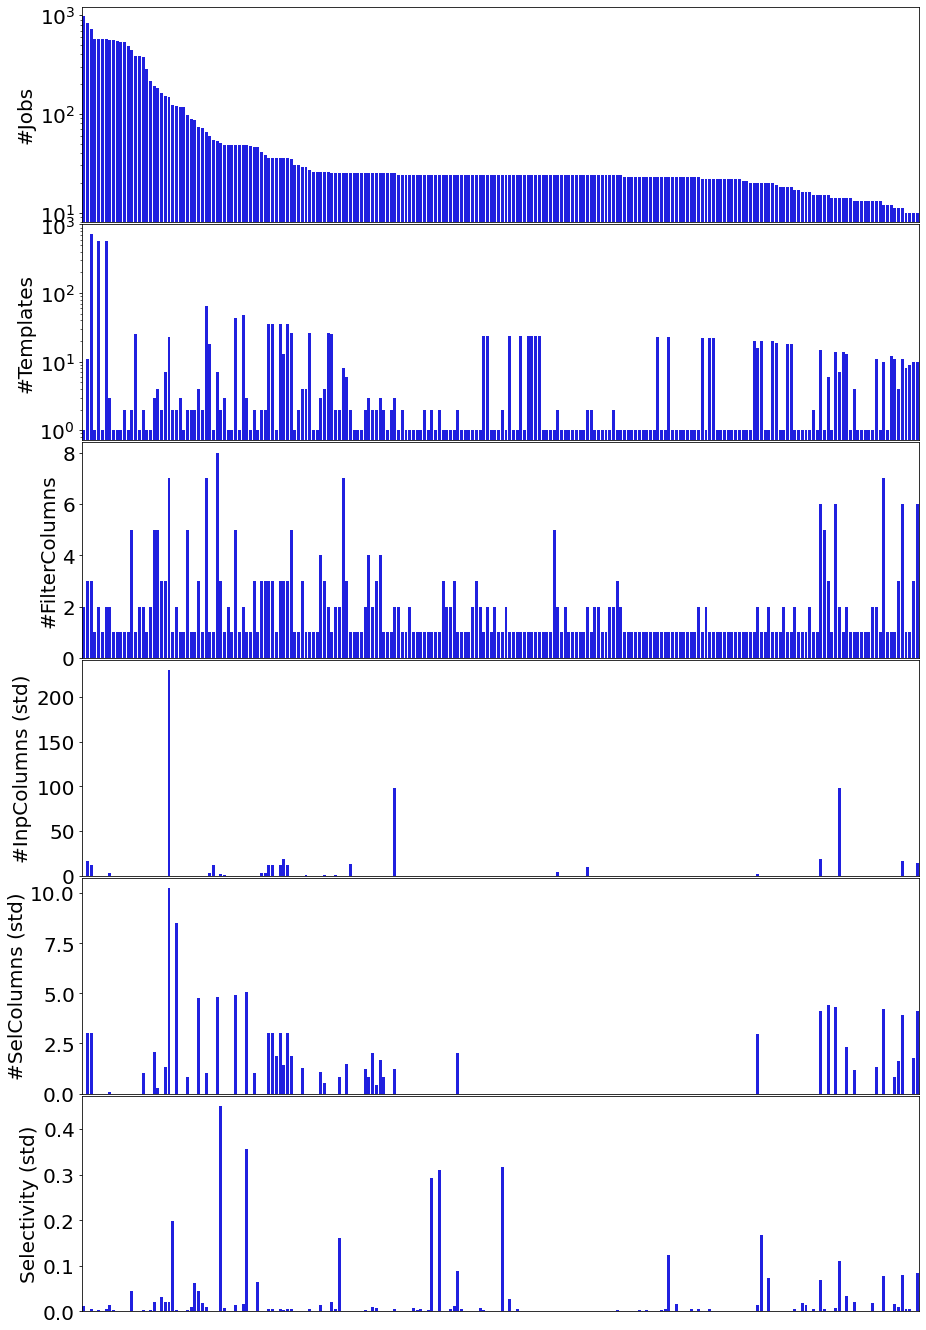

In [681]:
plot_input_stats(inp_stats, FIELDS5, "/Users/pari/Desktop/InputStats-Columns.pdf")

226
16619


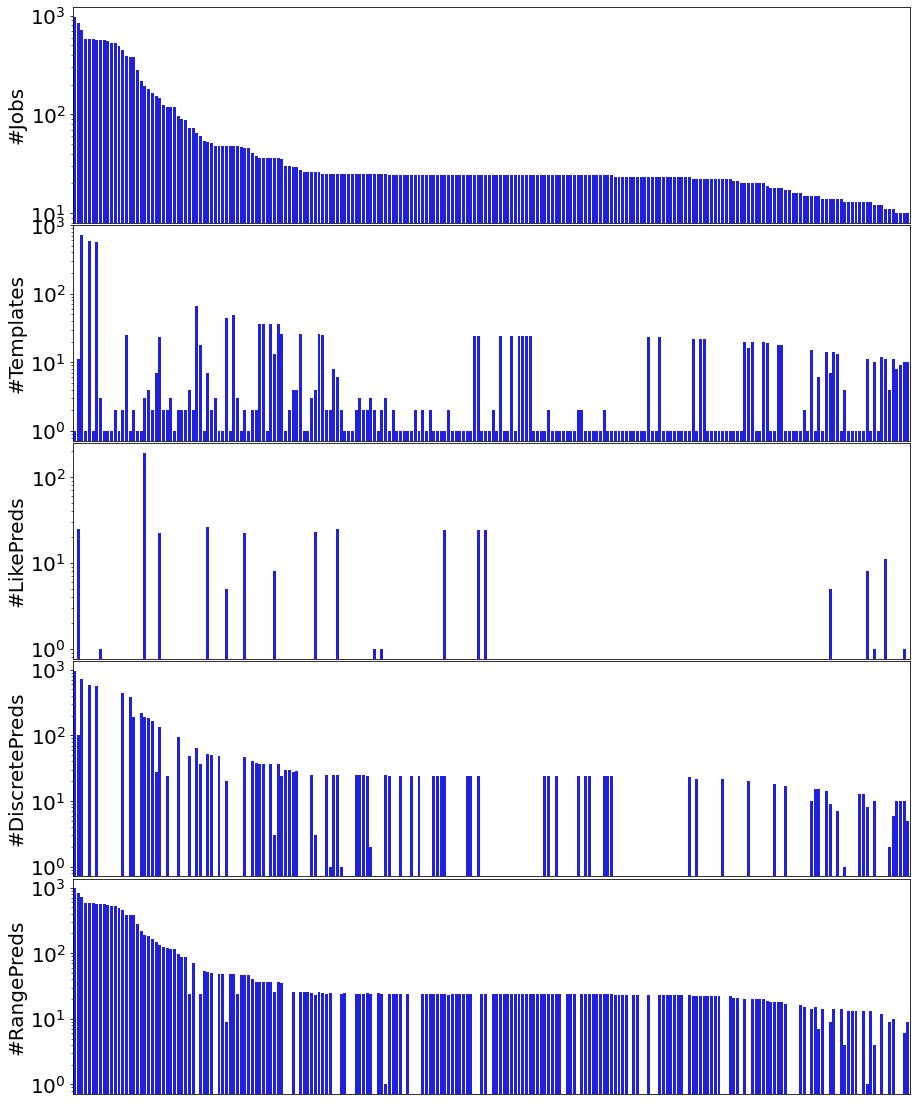

In [683]:
plot_input_stats(inp_stats, FIELDS, "/Users/pari/Desktop/InputStats-FilterKinds.pdf")

90
8108


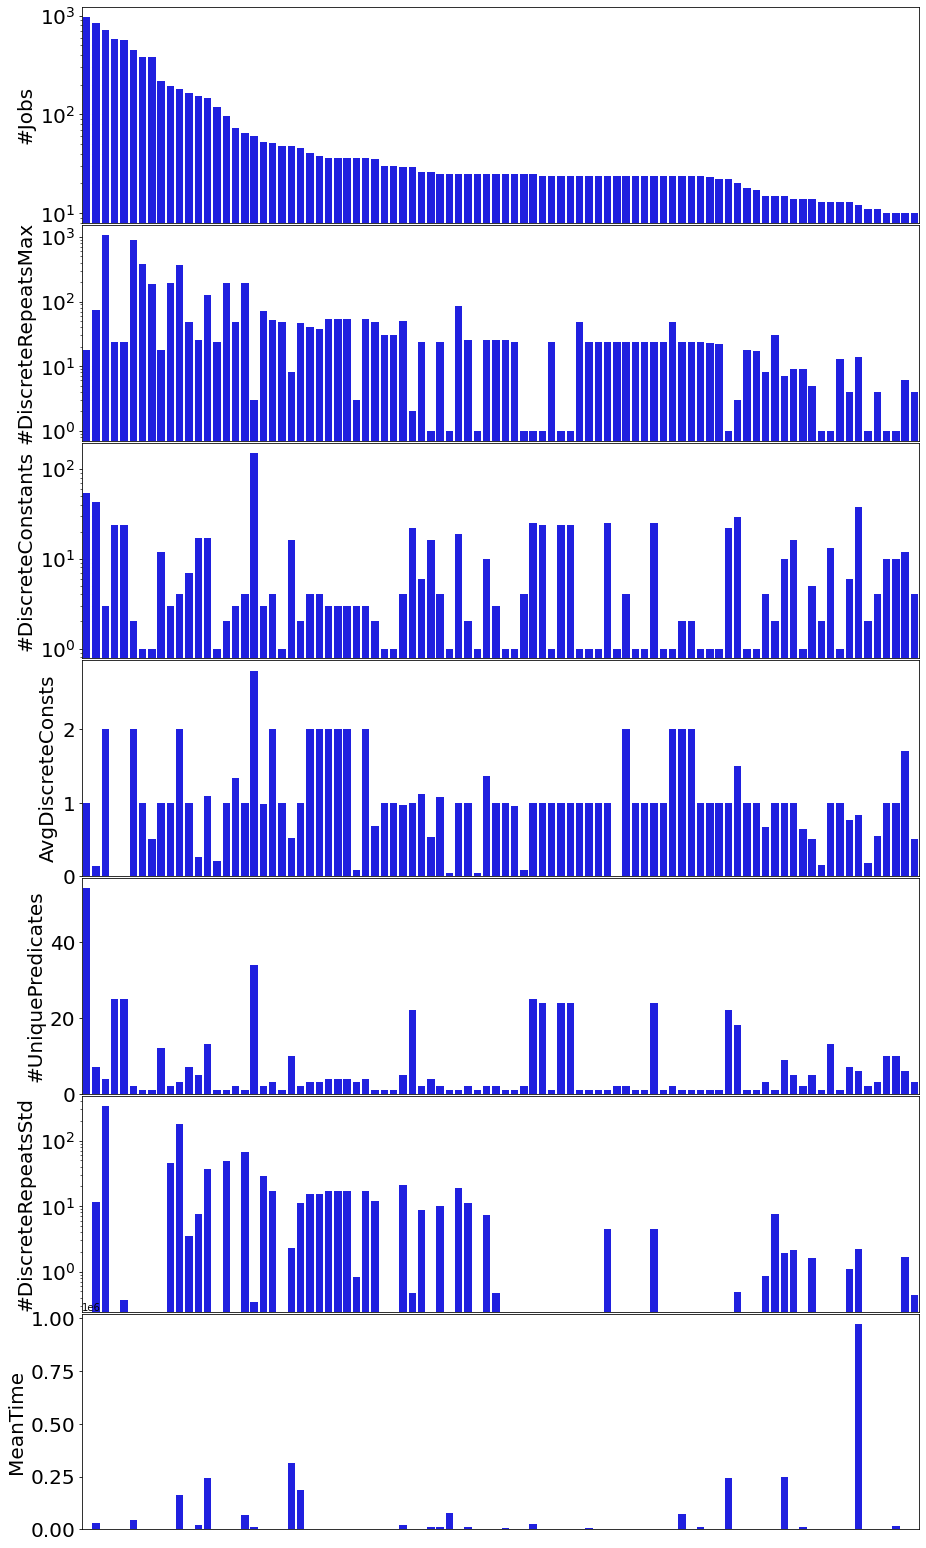

In [686]:
inp_stats2 = inp_stats[inp_stats["#DiscreteConstants"] != 0]
plot_input_stats(inp_stats2, FIELDS2, "/Users/pari/Desktop/InputStats-DiscreteConstants.pdf")

# Most of the repeated discrete values seem to be from shifting continuous values ---> sliding date windows

In [708]:
#inp_stats2.head(1)
for i in range(2):
    val = inp_stats2[INP_FIELD].values[i]
    #print(val)
    print(inp_to_discrete_consts[val])
    dfinp = df[df[INP_FIELD] == val]
    print(dfinp[FILTER_FIELD].values)

{'@"MSXLEADCOMPETITORS"': 18, '@"MSXLEAD"': 18, '@"MSXTERRITORY"': 18, '@"MSXCONSUMPTIONSERVICE"': 18, '@"MSXDYNAMICPROPERTY"': 18, '@"MSXPARTNERACCOUNT"': 18, '@"MSXBUSINESSUNIT"': 18, '@"MSXSALESORDER"': 18, '@"MSXPROCESSSTAGE"': 18, '@"MSXCONSENT"': 18, '@"MSXCAMPAIGN"': 18, '@"MSXLISTMEMBERBATCHES"': 18, '@"MSXLISTMEMBERS"': 18, '@"MSXPRODUCT"': 18, '@"MSXSELLERAPPCONSENT"': 18, '@"MSXTRANSACTIONCURRENCY"': 18, '@"MSXCOMPETITOR"': 18, '@"MSXEMAIL"': 18, '@"MSXSTRINGMAP"': 18, '@"MSXPRICELEVEL"': 18, '@"MSXLICENSINGPROGRAM"': 18, '@"MSXPRODUCTASSOCIATION"': 18, '@"MSXCAMPAIGNACTIVITY"': 18, '@"MSXAPP"': 18, '@"MSXSALESORDERDETAIL"': 18, '@"MSXCONTACT"': 18, '@"MSXACTIVITYPARTY"': 18, '@"MSXFAX"': 18, '@"MSXPHONECALL"': 18, '@"MSXOPPORTUNITYPRODUCT"': 18, '@"MSXTAXONOMYTYPE"': 18, '@"MSXCAMPAIGNRESPONSE"': 18, '@"MSXORDERCLOSE"': 18, '@"MSXAPPOINTMENT"': 18, '@"MSXACCOUNTDEVICEPROFILE"': 18, '@"MSXTAXONOMYTYPEDEPTH"': 18, '@"MSXOPPORTUNITYTEAM"': 18, '@"MSXCONSUMPTIONESTIMATE"': 18, 

In [ ]:
#INPNAME = "adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss"


20
2159


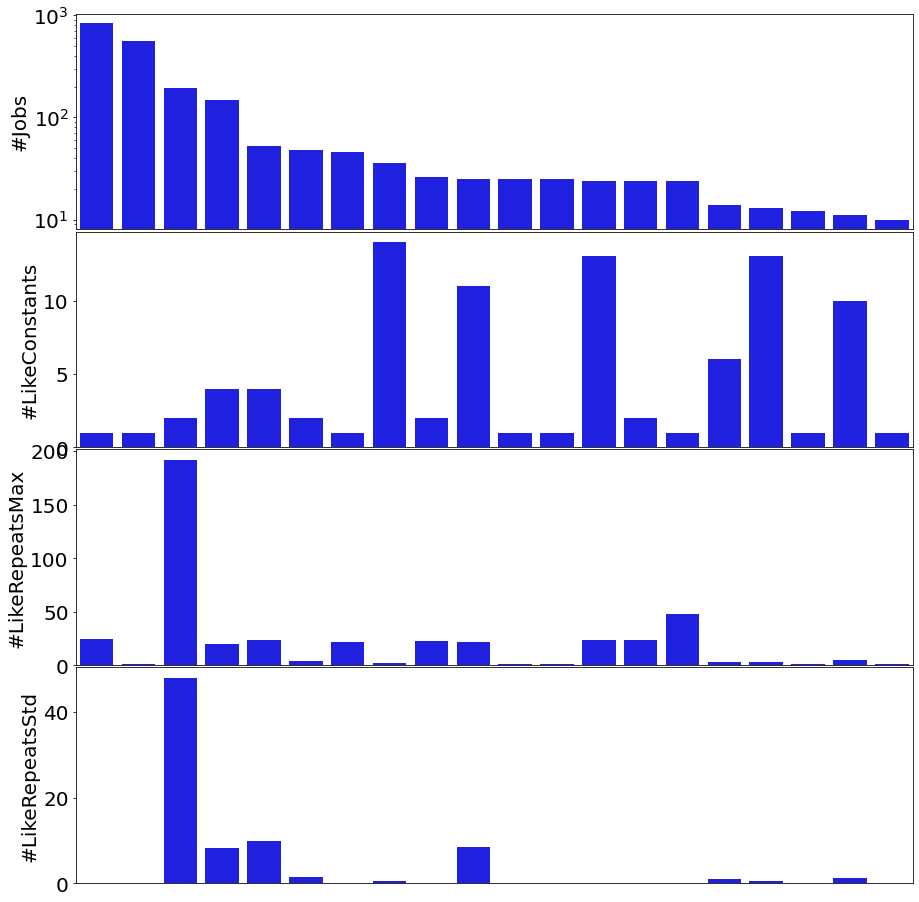

In [687]:
inp_stats3 = inp_stats[inp_stats["#LikeConstants"] != 0]
plot_input_stats(inp_stats3, FIELDS3, "/Users/pari/Desktop/InputStats-LikeConstants.pdf")

NameError: name 'inp_to_discdata' is not defined

226
16619


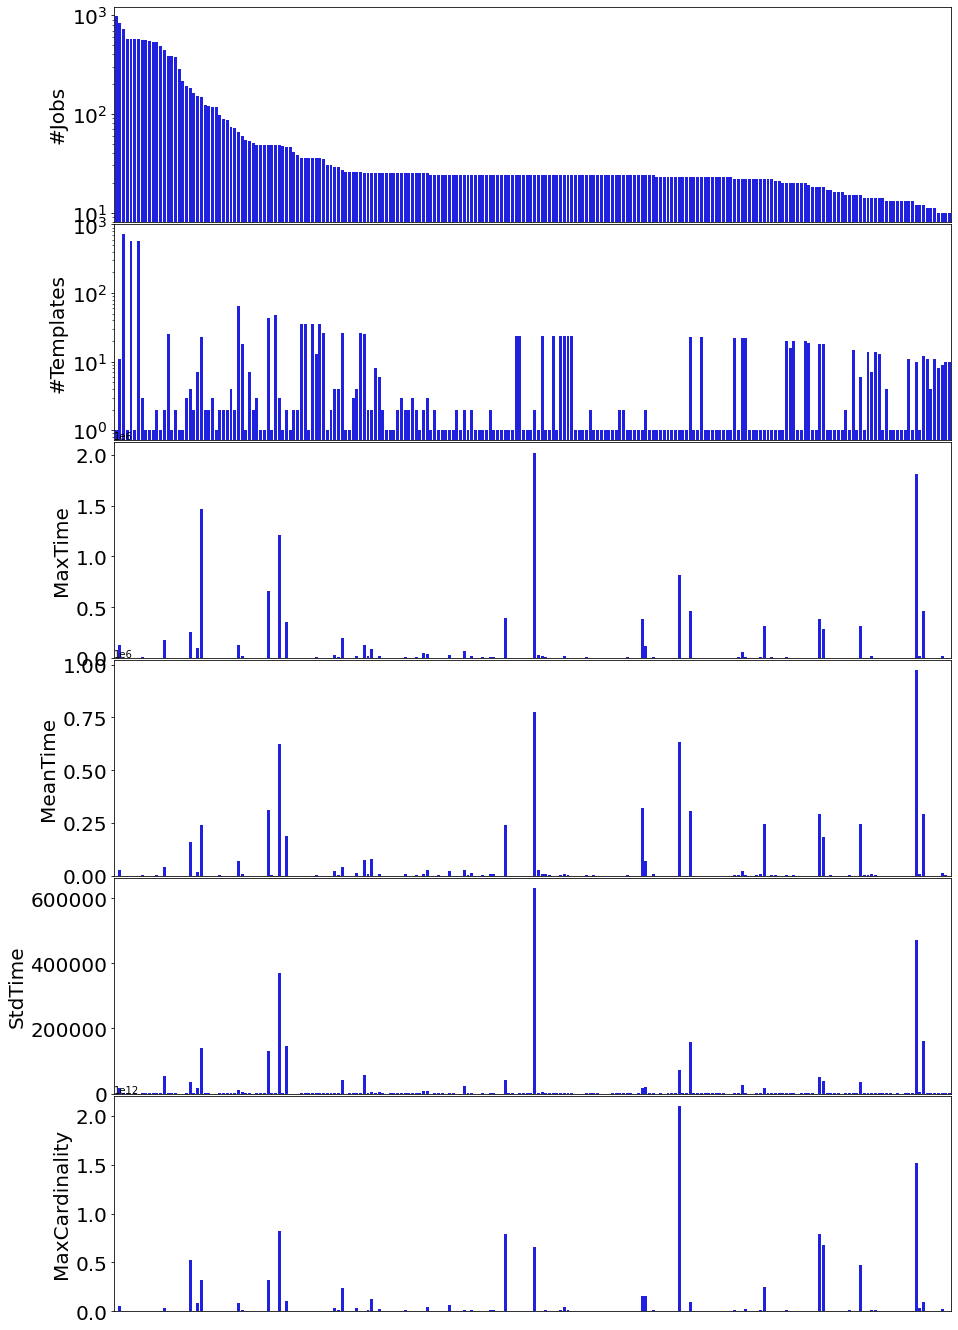

In [690]:
plot_input_stats(inp_stats, FIELDS4, "/Users/pari/Desktop/InputStats-Time.pdf")

# Exploring correlations

In [226]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InpColumns (std)', '#SelColumns (std)', '#FilterColumns',
       '#Templates', '#PartitionColumns', 'AvgDiscreteConsts', 'MaxTime',
       'MeanTime', 'StdTime', 'MaxCardinality', '#LikePreds', '#RangePreds',
       '#DiscretePreds', '#UDFPreds', '#InPreds', '#EqualtoDate',
       'AllFilterColumns', 'FilterInPartition', '#DiscreteRepeatsMax',
       '#DiscreteConstants', '#DiscreteRepeatsStd', '#UniquePredicates',
       '#LikeConstants', '#LikeRepeatsMax', '#LikeRepeatsStd'],
      dtype='object')

In [227]:
corr_matrix = inp_stats.corr().abs()
corr_matrix["MaxTime"].reset_index().sort_values(by="MaxTime", ascending=False)

,index,MaxTime
9,MaxTime,1.000000
11,StdTime,0.990607
10,MeanTime,0.946467
1,Selectivity (std),0.462000
12,MaxCardinality,0.263619
2,Cardinality (std),0.240504
6,#Templates,0.208141
19,AllFilterColumns,0.090456
17,#InPreds,0.051782
4,#SelColumns (std),0.050232


# Exploring discrete constants

In [561]:
inp2 = inp_stats.sort_values("#DiscreteConstants", ascending=False)
print(inp2["NormInput"].head(10).values)
inp2.head(100)

<StringArray>
[                                                    'adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Ingestion/MSaaSCase/Staging/Case.ss',
                          'adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss',
                                                      'adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Common/Dimensions/DimApp/VX/DimApp.ss',
 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MDG/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss',
            'adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss',
                                                                   'adl://iebks-proddata-cX.azuredatalakestore.net/local/xblpet/cooked/data/vulcandb/db

,NormInput,#Jobs,Selectivity (std),Cardinality (std),#InpColumns (std),#SelColumns (std),#FilterColumns,#Templates,#PartitionColumns,AvgDiscreteConsts,...,#EqualtoDate,AllFilterColumns,FilterInPartition,#DiscreteRepeatsMax,#DiscreteConstants,#DiscreteRepeatsStd,#UniquePredicates,#LikeConstants,#LikeRepeatsMax,#LikeRepeatsStd
206,adl://supportanalytics-cX.azuredatalakestore.n...,71,0.001113,16697762.262756,2.576789,0.0,1,18,0.0,2.521127,...,0,4,0,5,152,0.574708,34,0,0,0.0
24,adl://jarvis-prod-cX.azuredatalakestore.net/lo...,972,0.011565,295.506982,0.0,0.0,1,1,2.0,1.0,...,0,1,2,18,54,0.000000,54,0,0,0.0
791,adl://asimov-prod-data-cX.azuredatalakestore.n...,10,0.002359,176155032.70555,0.0,2.898275,2,7,1.0,6.0,...,0,3,0,3,47,0.492589,9,0,0,0.0
144,adl://asimov-prod-data-cX.azuredatalakestore.n...,120,0.000268,72927.008781,0.0,11.544288,1,3,3.0,46.0,...,0,1,2,120,46,0.000000,1,0,0,0.0
28,adl://asimov-prod-data-cX.azuredatalakestore.n...,882,0.004416,181374747.589422,15.775453,3.027561,2,19,2.938776,0.401361,...,0,6,1,84,43,13.273183,7,1,36,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,adl://protection-adhoc-cX.azuredatalakestore.n...,19,0.083748,34218.187507,12.296531,4.287886,6,18,2.0,0.842105,...,0,10,0,12,4,0.000000,3,0,0,0.0
695,adl://protection-adhoc-cX.azuredatalakestore.n...,20,0.081991,34950.804865,13.164546,4.536402,6,20,2.0,0.7,...,0,8,0,12,4,1.732051,3,0,0,0.0
317,adl://asimov-prod-data-cX.azuredatalakestore.n...,48,0.028858,6962020.947762,0.0,1.010582,3,2,1.0,1.5,...,0,3,0,48,4,10.392305,3,0,0,0.0
555,adl://asimov-prod-data-cX.azuredatalakestore.n...,24,0.0,682.532879,0.0,0.0,4,1,1.0,2.0,...,0,4,0,24,4,0.000000,2,0,0,0.0


In [566]:
inptmp = inp_stats[inp_stats["#Jobs"] == 4564]
#inptmp = inp_stats[inp_stats["#Jobs"] == 71]
#inptmp = inp_stats[inp_stats["Selectivity (std)"] == 0.001113]

#INPNAME = 'adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Ingestion/MSaaSCase/Staging/Case.ss'
#INPNAME = 'adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss'
#INPNAME = 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MDG/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss'
#inptmp = inp_stats[inp_stats["NormInput"] == INPNAME]

inpid = inptmp["NormInput"].values[0]
print(inpid)
df2 = df[df["NormInput"] == inpid]
print("Num unique jobs: ", len(set(df2["jobid"])))
print("Cols used: ", len(set(df2["unique_filter_cols"])))
print("Cont Ops used: ", set(df2["cont_ops"]))
print("Discrete ops used: ", set(df2["discrete_ops"]))
print("Like ops used: ", set(df2["like_ops"]))
print(df2.keys())
#df2
discdata = inp_to_discrete_consts[inpid]
print(discdata)
print(len(set(df2[FILTER_FIELD])))
print(df2[FILTER_FIELD].values[30])
print(len(set(df2["HashTagNonStrict"])))

adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Processed/BaseModel/Incident/Incident.Unified/Incident.Unified.ss
Num unique jobs:  621
Cols used:  4
Cont Ops used:  {0, 1}
Discrete ops used:  {0, 1}
Like ops used:  {0, 1}
Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'num_ops', 'num_unique_ops', 'unique_filter_cols',
       'num_cols_all', 'num_cols_sel', 'num_pcols', 'like_ops', 'discrete_ops',
       'cont_ops', 'udf_ops', 'in_ops', 'equal_dates', 'num_discrete_consts'],
      dtype='object')
{'"MSSolveODS"': 4530, 'null': 3, '"Closed"': 1}
36
{"isComparison":true,"expOperator":"!=","attribute":{"name":"DataSource:26","dataType":"String

# Exploring Like filters

In [ ]:
# for k,v in inp_to_discrete_consts.items():
#     print(k,v)
#     print("**********")

In [ ]:
#plot_input_stats(inp_stats, FIELDS3, "/Users/pari/Desktop/InputStats3-DiffTemplates.pdf")

# Most filters of the kind

In [ ]:
tmp_df = df[df.HashTagInput == 11700902958082612250]
print(tmp_df[FILTER_FIELD].values[0])

In [ ]:
tmp_df = df[df.HashTagInput == 3929217785330710594]
print(tmp_df[FILTER_FIELD].values[1])

In [ ]:
test_attr = tmp_df[FILTER_FIELD].values[1]
d = json.loads(test_attr)
col_names = extract_values(d, "name")
col_names

In [ ]:
test_attr

In [ ]:
len(inp_to_cols[3929217785330710594])

In [ ]:
test = inp_stats[inp_stats["HashTagInput"] == 3929217785330710594]
test

In [ ]:
inp_to_cols[test["HashTagInput"].values[0]]

In [ ]:
type(test["HashTagInput"].values[0])
#test = test.convert_dtypes()

In [ ]:
for idx,row in test.iterrows():
    print(type(row["HashTagInput"]))
    print(int(row["HashTagInput"]))
    print(row["HashTagInput"])

# Exploring columns per input

In [ ]:
df.groupby(["HashTagInput", "inputColumns"]).describe()

# How many sorted columns vs unsorted